In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
defaultPath='/content/drive/MyDrive/Animals_Dataset'

In [19]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

In [20]:

images_path = '/content/drive/MyDrive/Animals-151/acinonyx-jubatus/'
images = glob(images_path+'*.jpg')


len(images)

33

In [21]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf

path = '/content/drive/MyDrive/Animals-151/'

#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path, 
                                          target_size=(256, 256), 
                                          batch_size=340, 
                                          class_mode=None)

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #normalise to -1 and 1
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)


#Encoder

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same',strides=2))
model.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
#Decoder

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()


model.fit(X,Y,validation_split=0.1, epochs=300, batch_size=16)

model.save('other_files/colorize_autoencoder.model')




Found 2415 images belonging to 61 classes.
(340, 256, 256, 1)
(340, 256, 256, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 512)       1180160   
                                       

INFO:tensorflow:Assets written to: other_files/colorize_autoencoder.model/assets


In [22]:
tf.keras.models.load_model(
    'other_files/colorize_autoencoder.model',
    custom_objects=None,
    compile=True)
img1_color=[]
img1=img_to_array(load_img('/content/drive/MyDrive/acinonyx-jubatus-greyscale/11.jpg'))
img1 = resize(img1 ,(256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))
output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imsave("result.jpg", lab2rgb(result))

In [23]:
import sys
from skimage.metrics import structural_similarity as compare_ssim
from skimage.transform import resize
from matplotlib.pyplot import imread

img_a = resize(imread("/content/drive/MyDrive/Animals-151/acinonyx-jubatus/11.jpg"), (2*10, 2*10))
img_b = resize(imread("result.jpg"), (2*10, 2*10))

# score: {-1:1} measure of the structural similarity between the images
score, diff = compare_ssim(img_a, img_b, full=True, multichannel=True)
print(score)

0.9596358875295349


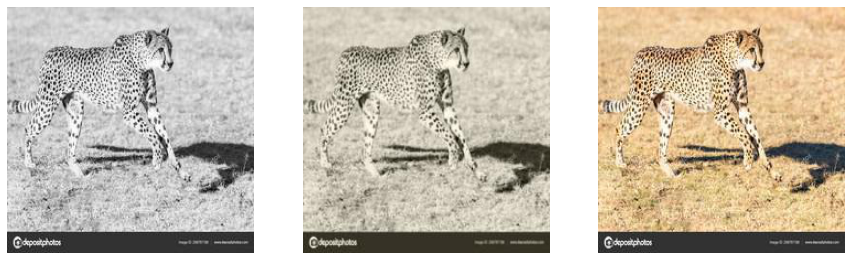

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
image_pairs = [
              #  ('outputs/color/img-7-epoch-28.jpg', 'outputs/gray/img-7-epoch-28.jpg'),
              #  ('outputs/color/img-1-epoch-28.jpg', 'outputs/gray/img-1-epoch-28.jpg'),
              #  ('outputs/color/img-2-epoch-28.jpg', 'outputs/gray/img-2-epoch-28.jpg'),
              ('result.jpg','/content/drive/MyDrive/acinonyx-jubatus-greyscale/11.jpg','/content/drive/MyDrive/Animals-151/acinonyx-jubatus/11.jpg'),
               #('outputs/color/img-4-epoch-28.jpg', 'outputs/gray/img-4-epoch-28.jpg','/content/drive/My Drive/Ani/class/103.jpg'),
               #('outputs/color/img-9-epoch-28.jpg', 'outputs/gray/img-9-epoch-28.jpg')
               ]
for c, g,o in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  true = mpimg.imread(o)
  f, axarr = plt.subplots(1, 3)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[2].imshow(true)
  axarr[0].axis('off'), axarr[1].axis('off'),axarr[2].axis('off')
  plt.show()

In [31]:
original = cv2.imread('/content/drive/MyDrive/Animals-151/acinonyx-jubatus/11.jpg')
historg = cv2.calcHist([original],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
historg = cv2.normalize(historg,historg).flatten()

In [32]:
pred = cv2.imread('result.jpg')
histpred = cv2.calcHist([pred],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
histpred = cv2.normalize(histpred,histpred).flatten()

In [33]:
d = cv2.compareHist(histpred,historg,cv2.HISTCMP_CHISQR)

In [34]:
d


1.9767629029033378